In [29]:
from models import *
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil
import os
print("Tensorflow version: ", tf.__version__)

excel_reports = ".\Excel reports"
saved_models = ".\Saved models"
trained_models = ".\Trained models"

#Get Ticker and Period
ticker = 'clb'
period = "1wk"

# #Delete folders
shutil.rmtree(excel_reports)
shutil.rmtree(saved_models)
shutil.rmtree(trained_models)

#Create folder, if exist pass exception
try:
    os.mkdir("Excel reports")
    os.mkdir("Saved models")
    os.mkdir("Trained models")
except:
    pass


Tensorflow version:  2.9.1


In [31]:
from transformers import PullData

#Initiate parameters
formation_window = 24
target_window = 4

#Do not change
window_size = formation_window + 1

#Print stuffs
print("window size: ",window_size)
print("formation_window: ",formation_window)
print("target_window: ",target_window)
print("chart period: ",period)

#training batches
batch_size_train = 8
batch_size_valid = 4

#Period model is trained and tested
start_date = '2020-01-01' #''2020-01-01   2015-01-01
end_date = '2022-08-17'  #'' 2022-08-17

GetData = PullData()

GetData.fit(ticker=ticker,
            start_date=start_date, 
            end_date=end_date, 
            interval=period, #1wk
            progress=False,
            condition=False,####################################
            form_window=formation_window,
            target_window=target_window,
            timeperiod1=6,
            timeperiod2=12,
            timeperiod3=24,
            export_excel=True,
            excel_path = excel_reports
            )

data_prep = GetData.transform()

#Validation
if window_size != (formation_window + 1):
    raise Exception(f"Error - window_size ({window_size}) must be equal to sum of formation_window ({formation_window}) and value 1.")
#data_prep

window size:  25
formation_window:  24
target_window:  4
chart period:  1wk
--------> PullData completed



In [32]:
####################################################################

from transformers import NormalizeData

NormalizeData = NormalizeData()

NormalizeData.fit(window_size=window_size, shuffle=False, debug=False,
                  export_excel=True, excel_path=excel_reports)

data_normalized, Dates = NormalizeData.transform(data_prep)

# Get only forecasts for model testing
# x_valid_x = data_normalized[['maxv','minv']].copy() #extreme values for reverting normalization
# x_valid = data_normalized.iloc[:,:-2].copy() #dataset for forecast


Dataframe shape:  (2750, 9)
Number of formations:  110
--------> NormalizeData completed



In [33]:
####################################################################

from training import SplitData

split_ratio = 0.80

SplitData = SplitData()

SplitData.fit(split_ratio=split_ratio, window_size=window_size,
              dates=Dates, debug=False, export_excel=True, excel_path=excel_reports)

x_train, x_valid, x_train_x, x_valid_x = SplitData.transform(data_normalized)



Split ratio: 80 %
train period: 2019-12-30 - 2022-02-07
valid period: 2021-09-06 - 2022-07-11
x_train window:  88.0
x_valid window:  22.0
--------> SplitData completed



In [34]:
from training import GetTensoredDataset

GetTensoredDataset = GetTensoredDataset()

GetTensoredDataset.fit(window_size=window_size, batch_size=batch_size_train, train=True, debug=False)

x_train_tensors, _ = GetTensoredDataset.transform(x_train)

# c = 0
# for batch in x_train_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break

--------> GetTensoredDataset completed



In [35]:
from training import GetTensoredDataset

GetTensoredValidDataset = GetTensoredDataset()

GetTensoredValidDataset.fit(
    window_size=window_size, batch_size=batch_size_valid, train=False, debug=False)

x_valid_tensors, labels = GetTensoredValidDataset.transform(x_valid)

# for batch in x_valid_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break

--------> GetTensoredDataset completed



<b>Model Training</b>

In [36]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{window_size}_{split_ratio}_{period}_{start_date}_{end_date}.h5'

early_stopping = EarlyStopping(
    monitor='val_loss', patience=6, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=10e-15,
                              verbose=1)

model_checkpoint = ModelCheckpoint(monitor='val_loss',
                                   filepath=model_name,
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]


def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true*y_pred, 0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                    )

    return(tf.reduce_mean(loss, axis=-1))


tf.keras.losses.sign_penalty = sign_penalty


Get Model

In [37]:
tf.random.set_seed(7788)
np.random.seed(7788)
print(f"Model training - {str.upper(ticker)} \n")

model = clb_model()


# model_baseline = tf.keras.models.Sequential([

#         tf.keras.layers.Conv1D(filters=4, kernel_size=1,
#                                strides=1, padding="same",
#                                activation=tf.nn.selu,
#                                input_shape=[None, 7]),
#       # tf.keras.layers.Conv1D(filters=16, kernel_size=1,
#       #                        strides=1, padding="same",
#       #                        activation=tf.nn.selu,
#       #                        #input_shape=[None, 7]
#       #                        ),

#       # tf.keras.layers.Bidirectional(
#       # tf.keras.layers.LSTM(12, return_sequences=True)),

#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
#         tf.keras.layers.Dense(3, activation=tf.nn.selu),

#         tf.keras.layers.Dense(2, activation=tf.nn.selu),
#         tf.keras.layers.Dense(1, activation=tf.nn.relu),
#     ])

optimizer2 = tf.keras.optimizers.Adam(
    learning_rate=0.0009, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
optimizer5 = tf.keras.optimizers.Adagrad(
    learning_rate=0.005, initial_accumulator_value=8, epsilon=1e-07, name='Adagrad')

model.compile(loss=sign_penalty,
              optimizer=optimizer5,
              )

model.fit(x_train_tensors, epochs=1200, callbacks=[
          callbacks], validation_data=x_valid_tensors)


Model training - CLB 

Epoch 1/1200
11/11 [==============================] - 11s 253ms/step - loss: 0.1166 - val_loss: 0.1111 - lr: 0.0050
Epoch 2/1200
11/11 [==============================] - 1s 58ms/step - loss: 0.1086 - val_loss: 0.1074 - lr: 0.0050
Epoch 3/1200
11/11 [==============================] - 1s 53ms/step - loss: 0.1040 - val_loss: 0.1034 - lr: 0.0050
Epoch 4/1200
11/11 [==============================] - 1s 65ms/step - loss: 0.1002 - val_loss: 0.1001 - lr: 0.0050
Epoch 5/1200
11/11 [==============================] - 1s 56ms/step - loss: 0.0973 - val_loss: 0.0973 - lr: 0.0050
Epoch 6/1200
11/11 [==============================] - 1s 50ms/step - loss: 0.0950 - val_loss: 0.0948 - lr: 0.0050
Epoch 7/1200
11/11 [==============================] - 1s 91ms/step - loss: 0.0931 - val_loss: 0.0927 - lr: 0.0050
Epoch 8/1200
11/11 [==============================] - 1s 54ms/step - loss: 0.0915 - val_loss: 0.0907 - lr: 0.0050
Epoch 9/1200
11/11 [==============================] - 1s 66ms/s

In [38]:
# model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{window_size}_{split_ratio}_{period}_{start_date}_{end_date}.h5'
# model_name = 'Saved models\STNE_24_4_25_0.8_2020-01-01_2022-08-17.h5'
# model = tf.keras.models.load_model(model_name, custom_objects={
#                                              'sign_penalty': sign_penalty})


In [39]:
def model_forecast(model, series, window_size, debug):
    """
    Get model, data and window size as an input. 
    Make prediction window is subtracted by 1, since we do not need label in window, 
    label value is skipped
    """
    c = 0

    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size-1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))

    if debug == True:
        # This block of code will print out data on which is made prediction
        for item in ds:
            c += 1
            if c < 3:
                print("\n"+str(c) + " prediction:\n ", item)
            else:
                break

    ds = ds.batch(1).prefetch(1)
    forecast = model.predict(ds)
    forecast2 = np.squeeze(forecast)
    return forecast2


forecast = model_forecast(model, x_valid, window_size=window_size, debug=False)
forecast[:2]


22/22 [==============================] - 2s 6ms/step


array([0.82031894, 0.81727827], dtype=float32)

In [40]:
# pr = x_valid.iloc[:24, :].to_numpy()
# pr = np.array([pr])
# pr = np.array([pr])
# pred = tf.data.Dataset.from_tensor_slices(pr)
# predict = model.predict(pred)
# print("Raw prediction: ", predict)


In [41]:
from transformers import ReverseNormalization

ReverseNormalization = ReverseNormalization()

ReverseNormalization.fit(forecasts=forecast, labels=labels,
                         x_valid=x_valid, x_valid_x=x_valid_x, window_size=window_size, debug=False)

df = ReverseNormalization.transform()
#df.head(25)

--------> ReverseNormalization completed



In [42]:
from final_evaluation import GetFinalDataframe

GetFinalDataframe = GetFinalDataframe()

GetFinalDataframe.fit(dates=Dates,
                      x_valid=x_valid)

reversed_df = GetFinalDataframe.transform(df)
#reversed_df.head(25)


--------> GetFinalDataframe



In [43]:
from final_evaluation import GetModelPerformance
#print(f"Window size: {window_size} \n")
print(f"ticker: {str.upper(ticker)}\n")
GetModelPerformance = GetModelPerformance()

GetModelPerformance.fit(acceptance=0,
                        penalization=0,
                        entry_candle='Current Open',
                        budget=10000,
                        window_size=window_size,
                        export_excel=True,
                        excel_path = excel_reports)

trades_df = GetModelPerformance.transform(reversed_df)
#trades_df.head(25)


ticker: CLB

Formations:  22
period: 2021-09-06 - 2022-07-11
Entry Candle:  Current Open

Total Trades:  21
Profit Trades:  15
Loss Trades:  6

Win Ratio: 71.0 %
Loss Ratio: 29 %

Trade nr with exact TP:  11
Ratio of exact TP: 52.0 %

Average profit per trade:  753

Gross profit:  15803
Gross loss:  -8545

Net profit:  7258


In [44]:
trade = 1
budget = 10000
entry_candle = 'Current Open'
# loss = trades_df[trades_df['profit']<0]
# loss['trade'].unique()
# trades_df.loc[trades_df['trade']==12]

Trade:  4
Window size:  25
Period: 2021-09-27 - 2022-03-07

Budget:  10000

Entry price:  31.49
Label (target):  34.08
Model prediction:  33.24
Market Change: 1.75 $
Profit: 555.73 $


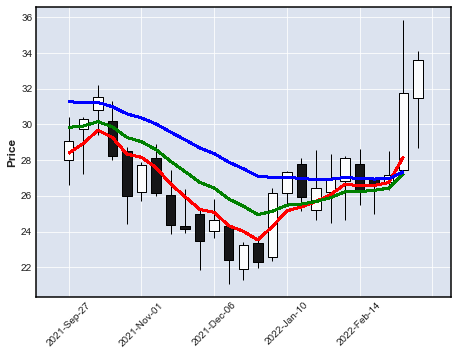

,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,Datetime,profit,trade
In,,,,,,,,,,,,
75,28.000000,30.430000,26.580000,29.049999,28.380757,29.832671,31.277589,nn,nn,2021-09-27,1.745079,4
76,29.730000,30.430000,27.219999,30.290001,28.926255,29.903030,31.198582,nn,nn,2021-10-04,1.745079,4
77,30.830000,32.220001,29.420000,31.540001,29.673040,30.154871,31.225895,nn,nn,2021-10-11,1.745079,4
78,30.190001,31.320000,28.000000,28.230000,29.260742,29.858737,30.986224,nn,nn,2021-10-18,1.745079,4
79,28.500000,28.750000,24.410000,26.010000,28.331959,29.266624,30.588126,nn,nn,2021-10-25,1.745079,4
80,26.219999,27.870001,25.690001,27.709999,28.154256,29.027143,30.357876,nn,nn,2021-11-01,1.745079,4
81,28.120001,28.920000,26.000000,26.129999,27.575897,28.581429,30.019646,nn,nn,2021-11-08,1.745079,4
82,26.070000,27.420000,23.870001,24.379999,26.662783,27.935055,29.568474,nn,nn,2021-11-15,1.745079,4
83,24.290001,26.360001,23.920000,24.139999,25.941988,27.351200,29.134196,nn,nn,2021-11-22,1.745079,4


In [45]:
trade = 4
from plotting import PlotTrade

df = PlotTrade(trade=trade,trades_df=trades_df,window_size=window_size,entry_candle=entry_candle,budget=budget)
trade += 1
df


In [46]:
from final_evaluation import GetPerformanceReport

GetPerformanceReport = GetPerformanceReport()

GetPerformanceReport.fit(entry_candle="Current Open",
                        budget=10000,
                        window_size=window_size,
                        export_excel=True,
                        excel_path = excel_reports)

trades_df_final = GetPerformanceReport.transform(trades_df)
trades_df_final


--------> GetPerformanceReport completed



,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,Datetime,profit,trade,Entry,Performance
0,27.700001,28.330000,26.270000,27.820000,28.875197,31.023395,32.221281,nn,nn,2021-09-06,6.189706,1,nn,nn
1,28.230000,29.160000,27.129999,27.500000,28.482283,30.481334,31.843578,nn,nn,2021-09-13,6.189706,1,nn,nn
2,26.270000,28.070000,26.030001,27.190001,28.113060,29.974975,31.471292,nn,nn,2021-09-20,6.189706,1,nn,nn
3,28.000000,30.430000,26.580000,29.049999,28.380757,29.832671,31.277589,nn,nn,2021-09-27,6.189706,1,nn,nn
4,29.730000,30.430000,27.219999,30.290001,28.926255,29.903030,31.198582,nn,nn,2021-10-04,6.189706,1,nn,nn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,20.730000,21.660000,18.410000,19.129999,23.463231,25.382189,26.643657,nn,nn,2022-06-20,0.690001,21,nn,nn
521,19.559999,20.920000,18.650000,19.830000,22.425165,24.528006,26.098565,nn,nn,2022-06-27,0.690001,21,nn,nn
522,19.200001,19.580000,17.350000,18.730000,21.369404,23.636005,25.509079,nn,nn,2022-07-04,0.690001,21,nn,nn
523,18.190001,18.549999,15.210000,15.880000,19.801003,22.442774,24.738753,nn,nn,2022-07-11,0.690001,21,nn,nn


In [47]:
from final_evaluation import MakeSinglePrediction

#split_ratio = 0.8

model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{window_size}_{split_ratio}_{period}_{start_date}_{end_date}.h5'

MakeSinglePrediction = MakeSinglePrediction()

fit_output = MakeSinglePrediction.fit(
                        model_name=model_name,
                        form_window=formation_window,
                        ticker=ticker,
                        start_date="2021-03-18",
                        end_date="2022-08-27",
                        interval='1wk',
                        progress=False,
                        condition=False,
                        timeperiod1=6,
                        timeperiod2=12,
                        timeperiod3=24,
                        debug=False,
                        budget=10000,
                        penalization=0,
                        acceptance=0,
                        entry_candle='Current Close')

#fit method outputs tuple, get only trade formation out of tuple
trade_formation = fit_output[1]
final_trade_formation = trade_formation.head(24)
final_trade_formation
###IMPORTANT!!!!
#trade_formation dataframe must be checked before transformation, sometimes df pulled via yahoo finance 
# is shifted, and trade formation does not have entire formation in itself. in this case there must 
# be changed end_date in fit method



,Date,Open,High,Low,Close,EMA6,EMA12,EMA24
52,2022-03-14,31.490000,32.459999,28.680000,29.000000,28.412579,27.520048,27.567639
53,2022-03-21,29.500000,32.160000,28.750000,31.980000,29.431842,28.206194,27.920627
54,2022-03-28,31.299999,32.900002,29.620001,32.430000,30.288459,28.856011,28.281377
55,2022-04-04,32.660000,34.080002,30.639999,33.619999,31.240327,29.588932,28.708467
56,2022-04-11,33.360001,34.060001,31.290001,33.610001,31.917377,30.207558,29.100590
57,2022-04-18,32.660000,34.020000,28.730000,29.170000,31.132412,30.047934,29.106143
58,2022-04-25,28.330000,28.330000,24.760000,26.000000,29.666009,29.425175,28.857651
59,2022-05-02,25.780001,27.540001,24.620001,27.469999,29.038577,29.124378,28.746639
60,2022-05-09,26.740000,26.740000,21.809999,23.360001,27.416127,28.237551,28.315708
61,2022-05-16,23.549999,25.250000,23.549999,24.520000,26.588662,27.665620,28.012051



Ticker:  clb

1/1 [==============================] - 2s 2s/step

Entry candle (Current Close)

Budget:  10000

Entry price:  16.85
Prediction:  18.64
Expected Market move:  1.79
Expected Profit:  1059.48


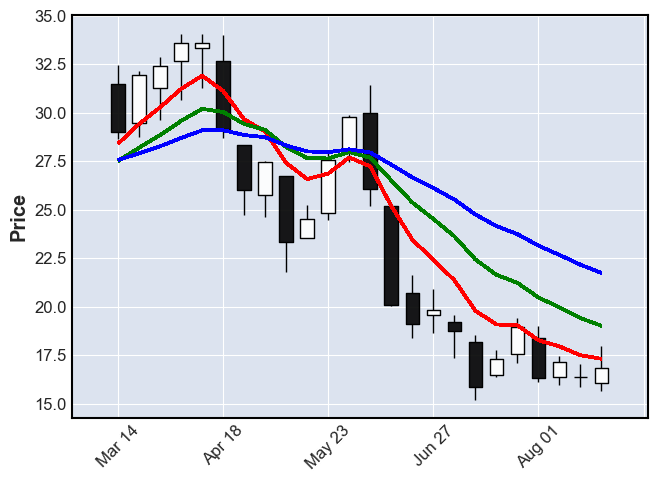

In [48]:
#Make prediction
MakeSinglePrediction.transform(final_trade_formation)

#PLot current chart
from plotting import PlotCurrentFormation
PlotCurrentFormation(final_trade_formation)
#18.75

<b>Record Predictions</b>

In [22]:
final_df = pd.DataFrame()
#List all predictions
dicti_prediction1 = {'ticker':['STNSE'],'Date':['21.8.2022'],'prediction':['12.97 (should be penalized by 2 - 10.97)'],'real market move':['pending']}
dicti_prediction2 = {'ticker':['CLB'],'Date':['21.8.2022'],'prediction':['18.6'],'real market move':['pending']}
dicti_prediction3 = {'ticker':['MRK'],'Date':['27.8.2022'],'prediction':['93.23'],'real market move':['pending']}

trades_tuple = (dicti_prediction1,dicti_prediction2,dicti_prediction3)
for item in trades_tuple:
    df_pred = pd.DataFrame(item)
    final_df = final_df.append(df_pred)
final_df

,ticker,Date,prediction,real market move
0,STNSE,21.8.2022,12.97 (should be penalized by 2 - 10.97),pending
0,CLB,21.8.2022,18.6,pending
0,MRK,27.8.2022,93.23,pending
